In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, confusion_matrix

## READ

In [4]:
# Read cleaned data

df = pd.read_csv('data/cleaned_credit_data2.csv')
print(df.shape)
df.head()

(6015, 14)


,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Credit_Score
0,28,34847,2,4,0.06,1,3,4,2,Good,605,0.33,326,Good
1,34,143162,1,5,0.08,3,8,6,3,Good,1303,0.38,220,Standard
2,34,131313,0,1,0.08,2,0,2,4,Good,352,0.29,374,Good
3,24,114838,2,5,0.07,3,11,11,8,Good,1377,0.28,263,Standard
4,36,54392,6,4,0.14,3,10,8,7,Standard,179,0.33,329,Standard


## Dummy Coding

In [5]:
# One Hot Encoder - Creating Dummy Variables 'Credit_Mix

ohe = preprocessing.OneHotEncoder(sparse=False)

oh_encoded = ohe.fit_transform(df[['Credit_Mix']])
df_oh_encoded = pd.DataFrame(oh_encoded, columns=ohe.get_feature_names_out(['Credit_Mix']))

df = pd.concat([df, df_oh_encoded], axis=1)

df.drop(['Credit_Mix'], axis=1, inplace=True)

df.head()


/Users/davidekim/tensorflow/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Credit_Score,Credit_Mix_Bad,Credit_Mix_Good,Credit_Mix_Standard
0,28,34847,2,4,0.06,1,3,4,2,605,0.33,326,Good,0.0,1.0,0.0
1,34,143162,1,5,0.08,3,8,6,3,1303,0.38,220,Standard,0.0,1.0,0.0
2,34,131313,0,1,0.08,2,0,2,4,352,0.29,374,Good,0.0,1.0,0.0
3,24,114838,2,5,0.07,3,11,11,8,1377,0.28,263,Standard,0.0,1.0,0.0
4,36,54392,6,4,0.14,3,10,8,7,179,0.33,329,Standard,0.0,0.0,1.0


## Split Data

In [6]:
# Separate X from y

outcome = 'Credit_Score'
predictors = list(df.columns)
predictors.remove(outcome)

X = df[predictors]
y = df[outcome]

In [7]:
# 0 - Good, 1 - Poor, 2 - Standard

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

In [8]:
# split dataset into training (70%) and test (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3, random_state=42, stratify=y)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(4210, 15) (1805, 15) (4210,) (1805,)


## Decision Tree

In [9]:
# Full Tree

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'gini', random_state = 42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy:  0.48642659279778394
[[135  44 182]
 [ 58 229 227]
 [188 228 514]]


In [10]:
print('Number of nodes', dt.tree_.node_count)

Number of nodes 2257


In [11]:
# Extremely overfit

y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

train_score = accuracy_score(y_train, y_pred_train)
test_score = accuracy_score(y_test, y_pred_test)

print('Accuracy score of full tree on training data =', round(train_score*100,1), '%')
print('Accuracy score of full tree on testing data =', round(test_score*100,1), '%')

Accuracy score of full tree on training data = 100.0 %
Accuracy score of full tree on testing data = 48.6 %


## Alphas

In [12]:
# Retrieve all the 'unique' values of penalty alpha and the impurity score
# they generate, from the full tree. We will use the cost_complexity_pruning_path() function
# To retrieve the alpha values, we need to call the option 'ccp_alphas'
alphas = dt.cost_complexity_pruning_path(X_train, y_train).ccp_alphas
alphas.shape

(604,)

In [13]:
# Create a decision tree for each possible value of alpha, and store the
# trees in an array called 'clfs'

clfs = [] # this creates an empty array (placeholder)

# now loop through all the possible alphas
for i in alphas:
    my_clf = DecisionTreeClassifier(random_state=0, ccp_alpha=i)
    my_clf.fit(X_train, y_train)
    clfs.append(my_clf) #this line adds to the fitted tree to the clfs[] array


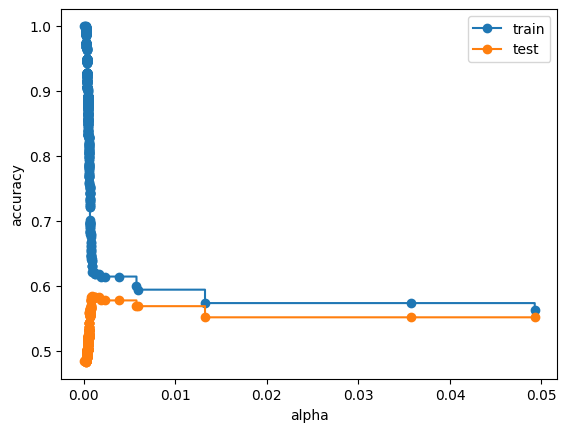

In [14]:
# Let's try to find the best alpha to use...
# We can plot the tree predictive accuracy as a function of alpha
train_scores = [accuracy_score(y_train, x.predict(X_train)) for x in clfs]
test_scores = [accuracy_score(y_test, x.predict(X_test)) for x in clfs]

# BTW, there is also an alternative function: score() that does the same thing
# train_scores = [x.score(X_train, y_train) for x in clfs]
# test_scores = [x.score(X_test, y_test) for x in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.plot(alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

## GridSearch

In [16]:
from sklearn.model_selection import GridSearchCV

# We create lists of all the values we want to search over
# This is called 'creating a grid'
param_grid = {
    'max_depth': range(1, 1002, 50),
    'min_samples_leaf': [1, 10, 20, 50, 100, 200],
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01],
    'ccp_alpha': np.arange(0, 0.02, 0.002)
}

# Then, use the GridSearchCV function which combines gridsearch with
# K-fold cross validation (cv parameter)
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10, scoring = 'accuracy', error_score='raise')
gridSearch.fit(X_train, y_train)

print('Best accuracy: ', gridSearch.best_score_)
print('Parameter values to achieve best accuracy: ', gridSearch.best_params_)

Best accuracy:  0.6071258907363419
Parameter values to achieve best accuracy:  {'ccp_alpha': 0.002, 'max_depth': 51, 'min_impurity_decrease': 0, 'min_samples_leaf': 1}


## Reduced Decision Tree

In [17]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'gini', random_state = 42, max_depth = 51, min_impurity_decrease = 0, min_samples_leaf = 1, ccp_alpha=0.002)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy:  0.5772853185595568
[[186  31 144]
 [ 28 224 262]
 [160 138 632]]


In [18]:
# Five-fold cross-validation of the decision tree using cross_val_score function
# We're going to use the tree stored in 'dt' variable
accuracy_scores = cross_val_score(dt, X_train, y_train, cv=10)
print('Accuracy scores of each fold: ', [f'{acc:.3f}' for acc in accuracy_scores])
print('5-fold cross-validation mean accuracy:', round(accuracy_scores.mean(),3))

Accuracy scores of each fold:  ['0.637', '0.618', '0.610', '0.584', '0.601', '0.603', '0.570', '0.625', '0.591', '0.632']
5-fold cross-validation mean accuracy: 0.607


In [19]:
print('Number of nodes', dt.tree_.node_count)

Number of nodes 15


In [20]:
from sklearn import tree

# Text representation of full tree
text_representation = tree.export_text(dt)
print(text_representation)

|--- feature_9 <= 1501.50
|   |--- feature_14 <= 0.50
|   |   |--- feature_6 <= 15.50
|   |   |   |--- feature_3 <= 5.50
|   |   |   |   |--- feature_3 <= 2.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_3 >  2.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- feature_3 >  5.50
|   |   |   |   |--- class: 2
|   |   |--- feature_6 >  15.50
|   |   |   |--- class: 1
|   |--- feature_14 >  0.50
|   |   |--- feature_4 <= 0.20
|   |   |   |--- class: 2
|   |   |--- feature_4 >  0.20
|   |   |   |--- class: 1
|--- feature_9 >  1501.50
|   |--- feature_9 <= 2435.00
|   |   |--- class: 1
|   |--- feature_9 >  2435.00
|   |   |--- class: 2



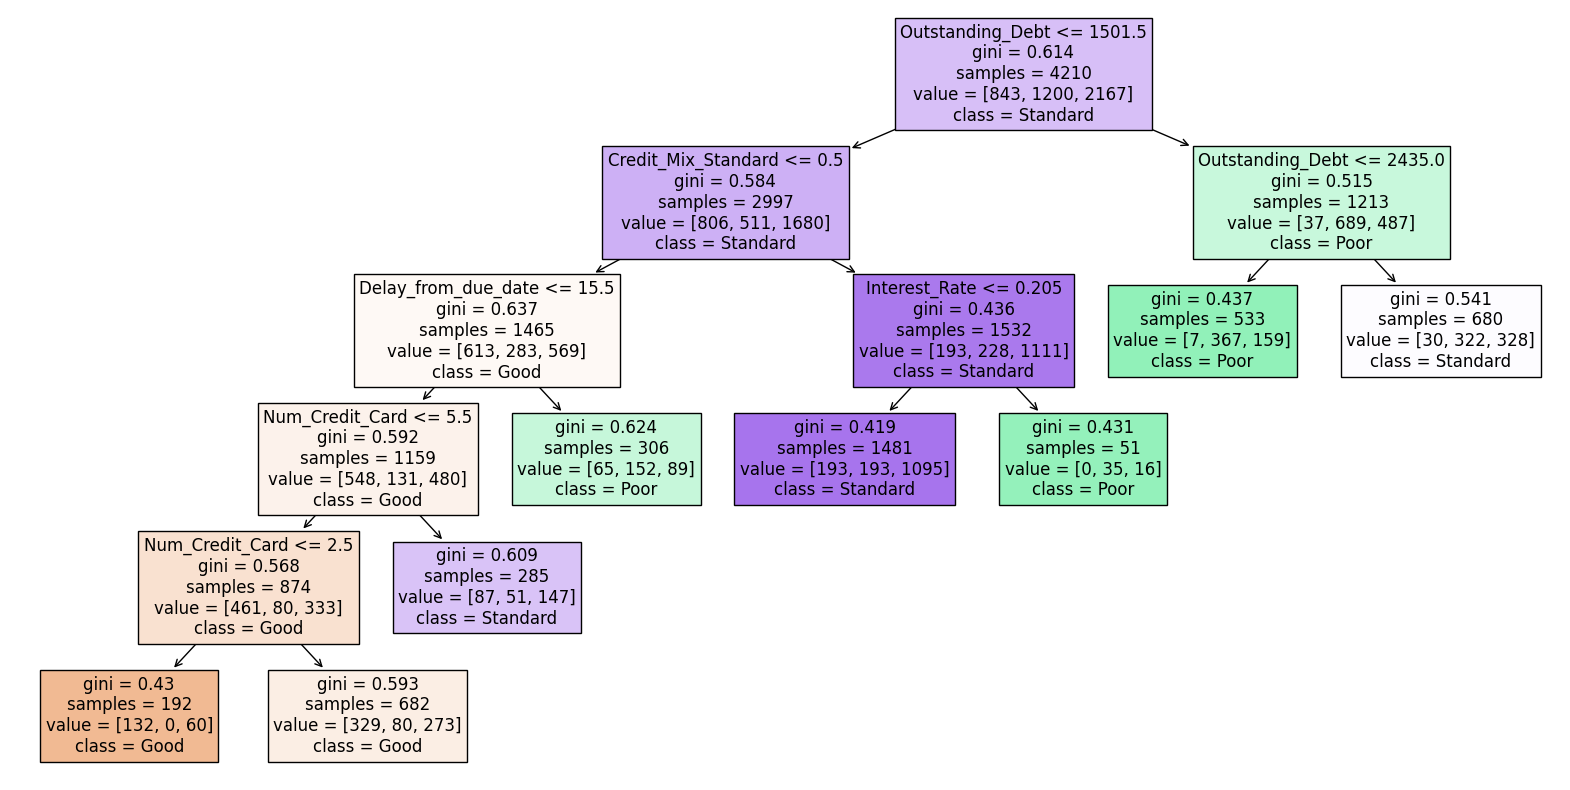

In [24]:
# Plot the reduced tree
fig = plt.figure(figsize=(20,10))
# define class names
tree.plot_tree(dt, fontsize=12, feature_names=X_train.columns, filled=True, class_names=['Good', 'Poor', 'Standard']);

/Users/davidekim/tensorflow/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


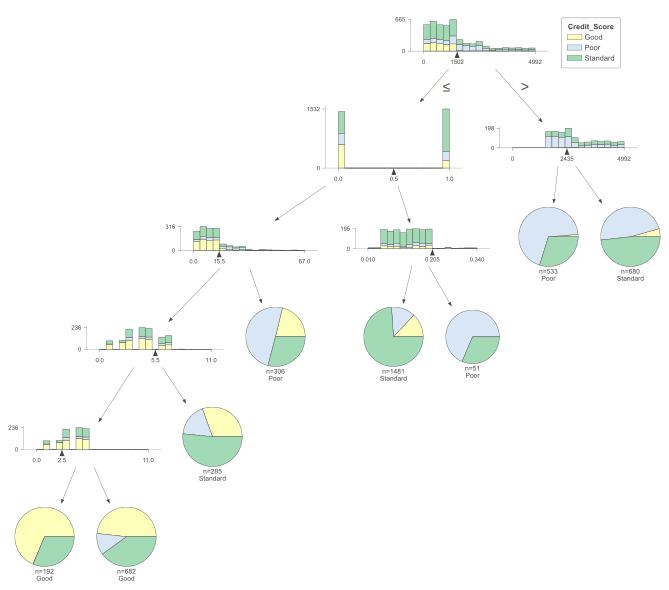

In [30]:
import dtreeviz

viz = dtreeviz.model(dt,
               X_train=X_train,
               y_train=y_train,
               target_name='Credit_Score',
               class_names=['Good', 'Poor', 'Standard'],
               );
viz.view()

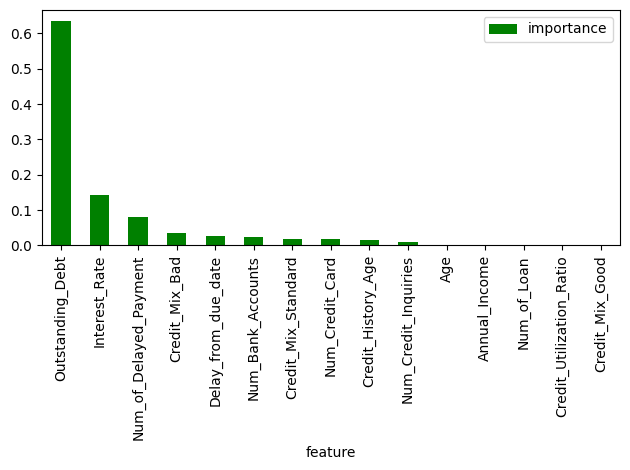

In [32]:
# Extract importance values for each feature (column of X)
importances = dt.feature_importances_

# create a dataframe to store the values and their labels
df2 = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# sort dataframe by descending order, showing the most important feature top
df2 = df2.sort_values('importance', ascending = False)

# plot the importance of each feature
ax = df2.plot(kind='bar', x='feature', color='green')

plt.tight_layout()
plt.show()

## Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 5000, criterion = 'gini', min_samples_leaf = 1, max_depth=51, random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy:  0.5922437673130194
[[165  15 181]
 [ 32 290 192]
 [143 173 614]]
